<a href="https://colab.research.google.com/github/jasimrashid/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
df.head()

,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
0,Donato's taco shop,California,1/18/2016,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,3.80,NaN,Scott,good fries: 4/5,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Oscar's Mexican food,California,1/24/2016,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,3.00,NaN,Scott,Fries: 3/5; too little meat,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Oscar's Mexican food,Carnitas,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,3.00,NaN,Emily,NaN,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Oscar's Mexican food,Carne asada,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,3.75,NaN,Ricardo,Go to average burrito place like Rigoberto's i...,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Pollos Maria,California,1/27/2016,Carlsbad,3055 Harding St,http://pollosmaria.com/,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,4.20,NaN,Scott,NaN,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
df.Burrito.value_counts()

California                    101
Carne asada                    29
California                     26
Carnitas                       23
Surf & Turf                    15
                             ... 
Chile relleno and carnitas      1
Barbacoa                        1
Bean and rice grande size       1
Steak with guacamole            1
carne asada                     1
Name: Burrito, Length: 132, dtype: int64

In [0]:
df.Burrito.value_counts()

California                    101
Carne asada                    29
California                     26
Carnitas                       23
Surf & Turf                    15
                             ... 
Chile relleno and carnitas      1
Barbacoa                        1
Bean and rice grande size       1
Steak with guacamole            1
carne asada                     1
Name: Burrito, Length: 132, dtype: int64

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

# print(california)

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

**1.** Train/Validate/Test split

In [54]:
# Do train/test split
# Use data from April & May 2016 to train
# Use data from June 2016 to test
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
cutoff_1 = pd.to_datetime('2017-01-01')
cutoff_2 = pd.to_datetime('2018-01-01')


train = df[df['Date'] < cutoff_1]
test = df[df['Date'] >= cutoff_2]
val = df[(df['Date'] < cutoff_2) & (df['Date'] >= cutoff_1)]

train.shape, validate.shape, test.shape

((298, 59), (85, 59), (38, 59))

**2.** baselines for classification

In [170]:
target = 'Great'
y_train = train[target]
y_val = val[target]
y_test = test[target]
print(y_train.value_counts(normalize=True))
print(y_val.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))


# 57% percent of burritos are rated great (test)
# 44% percent of burritos are rated great (validate)

False    0.590604
True     0.409396
Name: Great, dtype: float64
False    0.552941
True     0.447059
Name: Great, dtype: float64
True     0.578947
False    0.421053
Name: Great, dtype: float64


In [0]:
# Predict baseline target
majority_class = y_train.mode()[0]
y_pred = [majority_class]*len(y_train)
# y_pred

In [57]:
# Baseline accuracy score
from sklearn.metrics import accuracy_score

accuracy_score(y_pred, y_train)

0.5906040268456376

**3.** Logistic regression

In [58]:
train.describe(exclude='number')

,Burrito,Date,Chips,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
count,298,298,22,27,5,168,143,139,149,119,85,43,20,20,5,33,32,11,7,7,1,7,37,6,15,17,4,7,1,4,4,1,4,3,3,2,13,2,1,298
unique,5,110,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,2,1,2
top,California,2016-08-30 00:00:00,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,False
freq,118,29,19,27,3,130,115,101,121,97,63,29,19,17,3,24,24,9,5,4,1,5,33,5,9,9,3,5,1,4,4,1,4,3,3,2,13,1,1,176
first,NaN,2011-05-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2016-12-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 300
Data columns (total 59 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Burrito         298 non-null    object        
 1   Date            298 non-null    datetime64[ns]
 2   Yelp            71 non-null     float64       
 3   Google          71 non-null     float64       
 4   Chips           22 non-null     object        
 5   Cost            292 non-null    float64       
 6   Hunger          297 non-null    float64       
 7   Mass (g)        0 non-null      float64       
 8   Density (g/mL)  0 non-null      float64       
 9   Length          175 non-null    float64       
 10  Circum          174 non-null    float64       
 11  Volume          174 non-null    float64       
 12  Tortilla        298 non-null    float64       
 13  Temp            283 non-null    float64       
 14  Meat            288 non-null    float64       
 15  Fillin

In [0]:
# 1 import and instantiate log-reg class
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

# log_reg = LogisticRegression(solver='lbfgs')
log_reg = LogisticRegression()
# log_reg.fit(X_train_imputed, y_train)

# Arrange features and target

# 1: features = ['Yelp','Google'] #excluded 'Chips'#2 - validation accuracy 51%
# 2: features = ['Temp', 'Tortilla', 'Uniformity', 'Salsa','Synergy'] 
# 3: #2 plus beef plis avocado - 81%

# features = ['Temp', 'Tortilla', 'Uniformity', 'Salsa','Beef','Avocado','Synergy'] 
# features = ['Temp', 'Tortilla', 'Uniformity', 'Salsa','Beef','Avocado','Synergy','Google'] - 81%
# features = ['Temp', 'Tortilla', 'Uniformity', 'Salsa','Beef','Avocado','Synergy','Yelp','Cost'] #80%%
# features = ['Temp', 'Tortilla', 'Uniformity', 'Salsa','Beef','Avocado','Synergy','Yelp'] #82%
features = ['Temp', 'Tortilla', 'Uniformity', 'Salsa','Beef','Avocado','Synergy','Meat','Yelp'] #85%
# features = ['Temp', 'Tortilla', 'Uniformity', 'Salsa','Beef','Avocado','Synergy','Meat']


X_train = train[features]
X_val = val[features]


# 1-hot encoding
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

# Impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

# Apply scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

#comment: errors out on non-numerical feature chips

# Fit the model
# linear_reg.fit(X_train_imputed, y_train)




In [135]:
X_val.shape

(85, 5)

In [237]:
#Predict on imputed X - train
log_reg.fit(X_train_imputed, y_train)
y_pred = log_reg.predict(X_train_imputed)
print('Validation Accuracy on X_train_imputed', accuracy_score(y_train, y_pred))

Validation Accuracy on X_train_imputed 0.8791946308724832


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [238]:
#Predict on imputed X - validate
log_reg.fit(X_train_imputed, y_train)
y_pred = log_reg.predict(X_val_imputed)
print('Validation Accuracy on X_validate_imputed', accuracy_score(y_val, y_pred))

Validation Accuracy on X_validate_imputed 0.8352941176470589


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [239]:
#Predict on scaled X - train
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_train_scaled)
print('Validation Accuracy on X_train_scaled', accuracy_score(y_train, y_pred))

Validation Accuracy on X_train_scaled 0.8791946308724832


In [240]:
#Predict on scaled X - validate
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_val_scaled)
print('Validation Accuracy on X_validate_scaled', accuracy_score(y_val, y_pred))

Validation Accuracy on X_validate_scaled 0.8588235294117647


In [0]:
# Get model's test accuracy

In [241]:
X_test = test[features]
X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)
y_pred = log_reg.predict(X_test_scaled)

print('Validation Accuracy on X_test_scaled', accuracy_score(y_test, y_pred))

Validation Accuracy on X_test_scaled 0.8157894736842105


In [0]:
#Look at coefficients
coefficients = pd.Series(log_reg.coef_[0], X_train_encoded.columns)

**Extra** Explanatory visualizations

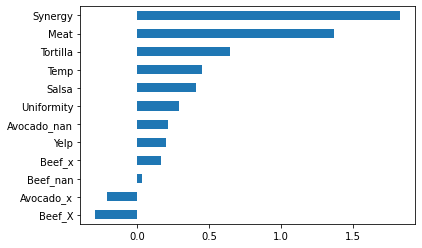

In [243]:
coefficients.sort_values().plot.barh()

In [0]:
# Question above: high coefficient for synergy -> reduce variance by eliminating variable instead of the equivalent of ridge regression? 

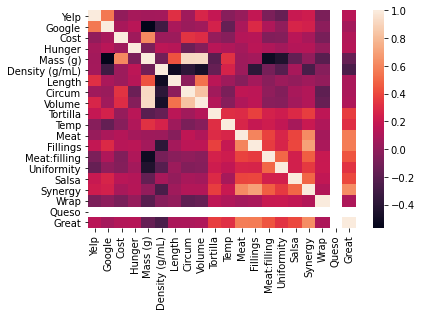

In [216]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(df.corr())